# Performance Comparison of Deep Learning Frameworks

## Image Preprocessing

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import csv, time, os.path
from six.moves import cPickle
from sklearn import model_selection as ms

In [2]:
# function for reading the images
# arguments: path to the traffic sign data, for example './GTSRB/Training'
# returns: list of images, list of corresponding labels 
def readTrafficSigns(rootpath, size, training=True):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.

    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns:   list of images, list of corresponding labels'''
    images = [] # images
    labels = [] # corresponding labels
    # loop over all 43 classes
    if training:
        for c in range(0,43):
            prefix = rootpath + '/' + format(c, '05d') + '/' # subdirectory for class
            gtFile = open(prefix + 'GT-'+ format(c, '05d') + '.csv') # annotations file
            gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
            gtReader.next() # skip header
            # loop over all images in current annotations file
            for row in gtReader:
#                 image = Image.open(prefix + row[0]).convert('L') # Load an image and convert to grayscale
                image = Image.open(prefix + row[0])
                box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
                image = image.crop(box) # Crop the ROI
                image = image.resize(size) # Resize images
                images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
                labels.append(int(row[7])) # the 8th column is the label
            gtFile.close()
    else:
        gtFile = open(rootpath + "/../../GT-final_test.csv") # annotations file
        gtReader = csv.reader(gtFile, delimiter=';') # csv parser for annotations file
        gtReader.next() # skip header
        # loop over all images in current annotations file
        for row in gtReader:
#             image = Image.open(rootpath + '/' + row[0]).convert('L') # Load an image and convert to grayscale
            image = Image.open(rootpath + '/' + row[0]) # Color version
            box = (int(row[3]), int(row[4]), int(row[5]), int(row[6])) # Specify ROI box
            image = image.crop(box) # Crop the ROI
            image = image.resize(size) # Resize images
            images.append(np.asarray(image).astype('uint8')) # the 1th column is the filename, while 3,4,5,6 are the vertices of ROI
            labels.append(int(row[7])) # the 8th column is the label
        gtFile.close()
        
    return images, labels

In [3]:
from sys import platform
global root
global epoch_num
if platform == "darwin":
    root = "/Users/moderato/Downloads/GTSRB/try"
else:
    root = "/home/zhongyilin/Desktop/GTSRB/try"
print(root)
train_dir = root + "/Final_Training/Images"
test_dir = root + "/Final_Test/Images"
resize_size = (49, 49)
epoch_num = 60
batch_size = 128

/home/zhongyilin/Desktop/GTSRB/try


trainImages list length 39209, trainLabels list length 39209
testImages list length 12630, testLabels list length 12630
(49, 49, 3)


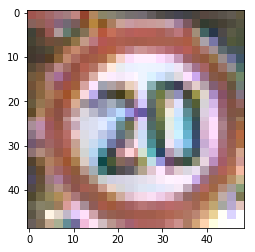

(49, 49, 3)


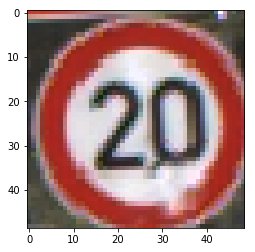

In [4]:
trainImages, trainLabels, testImages, testLabels = None, None, None, None

## If pickle file exists, read the file
if os.path.isfile(root + "/processed_images.pkl"):
    f = open(root + "/processed_images.pkl", 'rb')
    trainImages = cPickle.load(f, encoding="latin1")
    trainLabels = cPickle.load(f, encoding="latin1")
    testImages = cPickle.load(f, encoding="latin1")
    testLabels = cPickle.load(f, encoding="latin1")
    f.close()
## Else, read images and write to the pickle file
else:
    start = time.time()
    trainImages, trainLabels = readTrafficSigns(train_dir, resize_size)
    print("Training Image preprocessing finished in {:.2f} seconds".format(time.time() - start))

    start = time.time()
    testImages, testLabels = readTrafficSigns(test_dir, resize_size, False)
    print("Testing Image preprocessing finished in {:.2f} seconds".format(time.time() - start))
    
    f = open(root + "/processed_images.pkl", 'wb')
    for obj in [trainImages, trainLabels, testImages, testLabels]:
        cPickle.dump(obj, f, protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()

print("trainImages list length {:d}, trainLabels list length {:d}".format(len(trainImages), len(trainLabels)))
print("testImages list length {:d}, testLabels list length {:d}".format(len(testImages), len(testLabels)))

print(trainImages[42].shape)
plt.imshow(trainImages[42])
plt.show()

print(testImages[21].shape)
plt.imshow(trainImages[21])
plt.show()

## Intel Nervana Neon

In [5]:
from neon.backends import gen_backend, cleanup_backend
from neon.initializers import Gaussian, Constant, GlorotUniform
from neon.layers import GeneralizedCost, Affine
from neon.layers import Conv as neon_Conv, Dropout as neon_Dropout, Pooling as neon_Pooling
from neon.transforms import Rectlin, Softmax, CrossEntropyMulti, Misclassification, TopKMisclassification
from neon.models import Model
from neon.optimizers import GradientDescentMomentum as neon_SGD, ExpSchedule
from neon.callbacks.callbacks import Callbacks, LossCallback
from neon.data.dataiterator import ArrayIterator

mlp = None

# if os.path.isfile(root + "/saved_models/neon_weights.prm"):
#     print("Model exists")
# else:

neon_backends = ["cpu", "mkl", "gpu"]

for b in neon_backends:
    print("Use {} as backend.".format(b))
    
    # Set up backend
    # backend: 'cpu' for single, 'mkl' for multi-thread cpu, and 'gpu' for gpu
    be = gen_backend(backend=b, batch_size=batch_size, rng_seed=542, datatype=np.float32)

    # Make iterators
    x_train, x_valid, neon_y_train, neon_y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)
    neon_train_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_train]), y=np.asarray(neon_y_train), make_onehot=True, nclass=43, lshape=(3, resize_size[0], resize_size[1]))
    neon_valid_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in x_valid]), y=np.asarray(neon_y_valid), make_onehot=True, nclass=43, lshape=(3, resize_size[0], resize_size[1]))

    # Construct CNN
    neon_gaussInit = Gaussian(loc=0.0, scale=0.01)
    layers = []
    layers.append(neon_Conv((5, 5, 64), strides=2, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_conv1"))
    layers.append(neon_Pooling(2, op="max", strides=2, name="neon_pool1"))
    layers.append(neon_Conv((3, 3, 512), strides=1, padding=1, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_conv2"))
    layers.append(neon_Pooling(2, op="max", strides=2, name="neon_pool2"))
    layers.append(neon_Pooling(5, op="avg", name="neon_global_pool"))
    layers.append(Affine(nout=4096, init=neon_gaussInit, bias=Constant(0.0), activation=Rectlin(), name="neon_fc1"))
    layers.append(neon_Dropout(keep=0.5, name="neon_drop_out"))
    layers.append(Affine(nout=43, init=neon_gaussInit, bias=Constant(0.0), activation=Softmax(), name="neon_fc2"))

    # Initialize model object
    mlp = Model(layers=layers)

    # Costs
    neon_cost = GeneralizedCost(costfunc=CrossEntropyMulti())

    # Model summary
    mlp.initialize(neon_train_set, neon_cost)
    # print(mlp)

    # Learning rules
    neon_optimizer = neon_SGD(0.01, momentum_coef=0.9, gradient_clip_value=5, schedule=ExpSchedule(0.2))

    # Callbacks: validate on validation set
    callbacks = Callbacks(mlp, eval_set=neon_valid_set, output_file=root+"/callback_data_{}.h5".format(b))
    callbacks.add_callback(LossCallback(eval_set=neon_valid_set, epoch_freq=1))

    # Fit
    start = time.time()
    mlp.fit(neon_train_set, optimizer=neon_optimizer, num_epochs=epoch_num, cost=neon_cost, callbacks=callbacks)
    print("Neon training finishes in {:.2f} seconds.".format(time.time() - start))

    # Result
    results = mlp.get_outputs(neon_valid_set)

    # Print error on validation set
    start = time.time()
    neon_error_mis = mlp.eval(neon_valid_set, metric=Misclassification())*100
    print('Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_mis[0], time.time() - start))

    start = time.time()
    neon_error_top3 = mlp.eval(neon_valid_set, metric=TopKMisclassification(3))*100
    print('Top 3 Misclassification error = {:.1f}%. Finished in {:.2f} seconds.'.format(neon_error_top3[2], time.time() - start))

    mlp.save_params(root + "/saved_models/neon_weights_{}.prm".format(b))

    # Print error on test set
    neon_test_set = ArrayIterator(X=np.asarray([t.flatten().astype('float32')/255 for t in testImages]), y=np.asarray(testLabels), nclass=43, lshape=(3, resize_size[0], resize_size[1]))

    start = time.time()
    neon_error_mis_t = mlp.eval(neon_test_set, metric=Misclassification())*100
    print('Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_mis_t[0], time.time() - start))

    start = time.time()
    neon_error_top3_t = mlp.eval(neon_test_set, metric=TopKMisclassification(3))*100
    print('Top 3 Misclassification error = {:.1f}% on test set. Finished in {:.2f} seconds.'.format(neon_error_top3_t[2], time.time() - start))

    cleanup_backend()
    print("\n")

Use cpu as backend.
Epoch 0   [Train |████████████████████|  246/246  batches, 3.57 cost, 320.94s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 1   [Train |████████████████████|  245/245  batches, 3.49 cost, 314.28s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 2   [Train |████████████████████|  245/245  batches, 3.47 cost, 316.41s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 3   [Train |████████████████████|  245/245  batches, 3.46 cost, 316.36s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 4   [Train |████████████████████|  245/245  batches, 3.44 cost, 315.60s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 5   [Train |████████████████████|  245/245  batches, 3.43 cost, 315.15s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 6   [Train |████████████████████|  245/245  batches, 3.42 cost, 315.50s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 7   [Train |████████████████████|  245/245  batches, 3.42 cost, 316.39s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 8   [Train |████████████████████|  245/245  ba

Epoch 7   [Train |████████████████████|  245/245  batches, 3.51 cost, 103.23s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 8   [Train |████████████████████|  245/245  batches, 3.49 cost, 100.11s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 9   [Train |████████████████████|  245/245  batches, 3.49 cost, 99.82s]  [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 10  [Train |████████████████████|  245/245  batches, 3.77 cost, 104.89s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 11  [Train |████████████████████|  245/245  batches, 6.76 cost, 102.81s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 12  [Train |████████████████████|  245/245  batches, 6.75 cost, 102.98s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 13  [Train |████████████████████|  245/245  batches, 3.60 cost, 102.75s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 14  [Train |████████████████████|  245/245  batches, 4.79 cost, 103.78s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 15  [Train |████████████████████|  245/245  batches, 3.49 cost, 10

Epoch 15  [Train |████████████████████|  245/245  batches, 3.40 cost, 4.44s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 16  [Train |████████████████████|  245/245  batches, 3.40 cost, 4.45s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 17  [Train |████████████████████|  245/245  batches, 3.40 cost, 4.45s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 18  [Train |████████████████████|  246/246  batches, 3.41 cost, 4.47s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 19  [Train |████████████████████|  245/245  batches, 3.41 cost, 4.45s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 20  [Train |████████████████████|  245/245  batches, 3.40 cost, 4.46s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 21  [Train |████████████████████|  245/245  batches, 3.40 cost, 4.45s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 22  [Train |████████████████████|  245/245  batches, 3.39 cost, 4.45s] [CrossEntropyMulti Loss 0.00, 0.00s]
Epoch 23  [Train |████████████████████|  245/245  batches, 3.39 cost, 4.47s] [CrossEntro

## Keras with different multiple backends (Tensorflow, Theano, CNTK)

In [ ]:
from keras.layers import Conv2D as keras_Conv, MaxPooling2D as keras_MaxPooling, GlobalAveragePooling2D as keras_AveragePooling
from keras.layers import Dropout as keras_Dropout, Dense, Flatten
from keras.models import Sequential
from keras.utils import np_utils, to_categorical
from keras import backend as K
from keras.preprocessing import image
from keras.initializers import RandomNormal, Constant as keras_Constant
from keras.optimizers import SGD as keras_SGD
from keras.callbacks import ModelCheckpoint, Callback as keras_callback
from sklearn import model_selection as ms
from sklearn.preprocessing import OneHotEncoder
from keras.layers.convolutional import ZeroPadding2D
import os

In [ ]:
class LossHistory(keras_callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
# Function to dynamically change keras backend
from importlib import reload
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

In [ ]:
print(os.environ)

In [ ]:
from sys import platform
backends = ["theano", "tensorflow"]
if platform != "darwin":
    backends.append("cntk")
    
for b in backends:
    set_keras_backend(b)

    # Load and process images
    enc = OneHotEncoder(sparse=False)
    x_train, x_valid, y_train, y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)
    keras_train_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_train])
    keras_valid_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in x_valid])
    keras_test_x = np.vstack([np.expand_dims(image.img_to_array(x), axis=0).astype('float32')/255 for x in testImages])
    keras_train_y = to_categorical(y_train, 43)
    keras_valid_y = to_categorical(y_valid, 43)
    keras_test_y = to_categorical(testLabels, 43)

    # Build model
    keras_gaussInit = RandomNormal(mean=0.0, stddev=0.01, seed=542)
    layer_name_prefix = b+"_"

    keras_model = Sequential()
    keras_model.add(keras_Conv(64, (5, 5), kernel_initializer=keras_gaussInit, strides=(2, 2), bias_initializer=keras_Constant(0.0), activation="relu", input_shape=(resize_size[0], resize_size[1], 3), name=layer_name_prefix+"conv1"))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2), name=layer_name_prefix+"pool1"))
    # keras_model.add(ZeroPadding2D(padding=(1, 1), name=layer_name_prefix+"zero_padding"))
    # keras_model.add(keras_Conv(256, (3, 3), kernel_initializer=keras_gaussInit, strides=(1, 1), bias_initializer=keras_Constant(0.0), activation="relu", name=layer_name_prefix+"conv2"))
    keras_model.add(keras_Conv(256, (3, 3), kernel_initializer=keras_gaussInit, strides=(1, 1), padding="same", bias_initializer=keras_Constant(0.0), activation="relu", name=layer_name_prefix+"conv2"))
    keras_model.add(keras_MaxPooling(pool_size=(2, 2), name=layer_name_prefix+"pool2"))
    keras_model.add(keras_AveragePooling(name=layer_name_prefix+"global_pool"))
#     keras_model.add(Flatten(name=layer_name_prefix+"flatten")) # An extra layer to flatten the previous layer in order to connect to fully connected layer
    keras_model.add(Dense(4096, kernel_initializer=keras_gaussInit, bias_initializer=keras_Constant(0.0), activation="relu", name=layer_name_prefix+"fc1"))
    keras_model.add(keras_Dropout(0.5, name=layer_name_prefix+"drop_out"))
    keras_model.add(Dense(43, kernel_initializer=keras_gaussInit, bias_initializer=keras_Constant(0.0), activation="softmax", name=layer_name_prefix+"fc2"))
    keras_model.summary()

    keras_optimizer = keras_SGD(lr=0.01, decay=1.6e-8, momentum=0.9)
    keras_cost = "categorical_crossentropy"
    keras_model.compile(loss=keras_cost, optimizer=keras_optimizer, metrics=["acc"])

    checkpointer = ModelCheckpoint(filepath=root+"/saved_models/keras_"+b+"_weights.hdf5",
                                       verbose=1, save_best_only=True)

    start = time.time()
    keras_model.fit(keras_train_x, keras_train_y,
                  validation_data=(keras_valid_x, keras_valid_y),
                  epochs=epoch_num, batch_size=batch_size, callbacks=[checkpointer, LossHistory()], verbose=1, shuffle=True)
    print("{} training finishes in {:.2f} seconds.".format(b, time.time() - start))

    keras_model.load_weights(root+"/saved_models/keras_"+b+"_weights.hdf5")
    keras_predictions = [np.argmax(keras_model.predict(np.expand_dims(feature, axis=0))) for feature in keras_test_x]

    # report test accuracy
    keras_test_accuracy = 100*np.sum(np.array(keras_predictions)==np.argmax(keras_test_y, axis=1))/len(keras_predictions)
    print('{} test accuracy: {:.1f}%'.format(b, keras_test_accuracy))

## PyTorch

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import datasets, transforms
from torch.autograd import Variable

In [ ]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Build model
        self.conv = torch.nn.Sequential()
        self.conv.add_module("torch_conv1", torch.nn.Conv2d(3, 64, kernel_size=(5, 5), stride=2))
        self.conv.add_module("torch_pool1", torch.nn.MaxPool2d(kernel_size=2))
        self.conv.add_module("torch_relu1", torch.nn.ReLU())
        self.conv.add_module("torch_conv2", torch.nn.Conv2d(64, 256, kernel_size=(3, 3), stride=1, padding=1))
        self.conv.add_module("torch_pool2", torch.nn.MaxPool2d(kernel_size=2))
        self.conv.add_module("torch_relu2", torch.nn.ReLU())
        self.conv.add_module("torch_global_pool", torch.nn.AvgPool2d(kernel_size=5))
        
        self.csf = torch.nn.Sequential()
        self.csf.add_module("torch_fc1", torch.nn.Linear(256, 4096))
        self.csf.add_module("torch_relu3", torch.nn.ReLU())
        self.csf.add_module("torch_dropout1", torch.nn.Dropout(0.5))
        self.csf.add_module("torch_fc2", torch.nn.Linear(4096, 43))
        
        # Initialize conv layers and fc layers
        torch.nn.init.normal(self.conv.state_dict()["torch_conv1.weight"], mean=0, std=0.01)
        torch.nn.init.constant(self.conv.state_dict()["torch_conv1.bias"], 0.0)
        torch.nn.init.normal(self.conv.state_dict()["torch_conv2.weight"], mean=0, std=0.01)
        torch.nn.init.constant(self.conv.state_dict()["torch_conv2.bias"], 0.0)
        torch.nn.init.normal(self.csf.state_dict()["torch_fc1.weight"], mean=0, std=0.01)
        torch.nn.init.constant(self.csf.state_dict()["torch_fc1.bias"], 0.0)
        torch.nn.init.normal(self.csf.state_dict()["torch_fc2.weight"], mean=0, std=0.01)
        torch.nn.init.constant(self.csf.state_dict()["torch_fc2.bias"], 0.0)

    def forward(self, x):
        x = self.conv.forward(x)
        x = x.view(-1, 256)
        return self.csf.forward(x)

In [ ]:
x_train, x_valid, y_train, y_valid = ms.train_test_split(trainImages, trainLabels, test_size=0.2, random_state=542)

torch_train_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in x_train])
torch_train_y = torch.LongTensor(y_train)
torch_valid_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in x_valid])
torch_valid_y = torch.LongTensor(y_valid)
torch_test_x = torch.stack([torch.Tensor(i.swapaxes(0,2).astype("float32")/255) for i in testImages])
torch_test_y = torch.LongTensor(testLabels)

torch_tensor_train_set = utils.TensorDataset(torch_train_x, torch_train_y)
torch_train_set = utils.DataLoader(torch_tensor_train_set, batch_size=batch_size, shuffle=True)
torch_tensor_valid_set = utils.TensorDataset(torch_valid_x, torch_valid_y)
torch_valid_set = utils.DataLoader(torch_tensor_valid_set, batch_size=batch_size, shuffle=True)
torch_tensor_test_set = utils.TensorDataset(torch_test_x, torch_test_y)
torch_test_set = utils.DataLoader(torch_tensor_test_set, batch_size=batch_size, shuffle=True)

torch_model = ConvNet()
optimizer = optim.SGD(torch_model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def train(epoch):
    torch_model.train()
    for batch_idx, (data, target) in enumerate(torch_train_set):
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = torch_model(data)
        cost = torch.nn.CrossEntropyLoss(size_average=True)
        loss = cost(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(torch_train_set.dataset),
                100. * batch_idx / len(torch_train_set), loss.data[0]))
def test():
    torch_model.eval()
    test_loss = 0
    correct = 0
    for data, target in torch_test_set:
#         if args.cuda:
#             data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = torch_model(data)
        cost = torch.nn.CrossEntropyLoss(size_average=False)
        test_loss += cost(output, target).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(torch_test_set.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(torch_test_set.dataset),
        100. * correct / len(torch_test_set.dataset)))

In [ ]:
for epoch in range(1, epoch_num + 1):
    train(epoch)
test()